In [1]:
import os
from os import path
os.sys.path.append('../core/')
from mangle import *#cube_mangle
from astropy.io import fits
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy.stats import sigma_clipped_stats
import astropy.units as u
from astropy.wcs import WCS
from copy import deepcopy
from calibrimbore.bill import get_skymapper_region
%matplotlib widget

from scipy.ndimage.filters import convolve
from scipy.ndimage import gaussian_filter
from copy import deepcopy

from astropy.coordinates import SkyCoord, Angle
from astropy import units as u
import pandas as pd
from astroquery.vizier import Vizier

from scipy.optimize import minimize
import astropy.table as at

from photutils import DAOStarFinder
from astropy.stats import sigma_clipped_stats

def get_gaia_region(ra,dec,size=0.4, magnitude_limit = 21):
    """
    Get the coordinates and mag of all gaia sources in the field of view.

    -------
    Inputs-
    -------
        tpf 				class 	target pixel file lightkurve class
        magnitude_limit 	float 	cutoff for Gaia sources
        Offset 				int 	offset for the boundary 

    --------
    Outputs-
    --------
        coords 	array	coordinates of sources
        Gmag 	array 	Gmags of sources
    """
    c1 = SkyCoord(ra, dec, unit='deg')
    Vizier.ROW_LIMIT = -1

    result = Vizier.query_region(c1, catalog=["I/355/gaiadr3"],
                                     radius=Angle(size, "arcsec"),column_filters={'Gmag':f'<{magnitude_limit}'})

    keys = ['objID','RAJ2000','DEJ2000','e_RAJ2000','e_DEJ2000','gmag','e_gmag','gKmag','e_gKmag','rmag',
            'e_rmag','rKmag','e_rKmag','imag','e_imag','iKmag','e_iKmag','zmag','e_zmag','zKmag','e_zKmag',
            'ymag','e_ymag','yKmag','e_yKmag','tmag','gaiaid','gaiamag','gaiadist','gaiadist_u','gaiadist_l',
            'row','col']


    no_targets_found_message = ValueError('Either no sources were found in the query region '
                                          'or Vizier is unavailable')
    if result is None:
        raise no_targets_found_message
    elif len(result) == 0:
        raise no_targets_found_message


    result = result['I/355/gaiadr3'].to_pandas()
    result = result.rename(columns={'RA_ICRS':'ra','DE_ICRS':'dec'})
    return result

/var/folders/db/hdghk6ts5g11hr10jq0ss625nf1ny2/T/ipykernel_36106/3991158610.py:18: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import convolve


In [2]:
hdul = fits.open('2I_DATACUBE_FINAL_2019-12-31T06:22:04.886.fits')
wcs = WCS('2I_DATACUBE_FINAL_2019-12-31T06:22:04.886.fits')

hdul = fits.open('2I_DATACUBE_FINAL_2020-03-19T05:46:49.016.fits')
wcs = WCS('2I_DATACUBE_FINAL_2020-03-19T05:46:49.016.fits')

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


In [483]:
wcs = WCS(hdul[1].header)
data = hdul[1].data
cube = deepcopy(data)
cube[np.isnan(cube)] = 0

_,_,lam = wcs.all_pix2world(0,0,np.arange(0,len(cube)),0)
lam = lam * 1e10

In [4]:
ra,dec, _ = wcs.all_pix2world(data.shape[2]/2,data.shape[1]/2,100,0)

In [5]:
#cat = get_skymapper_region([ra],[dec],size=100)
cat = get_gaia_region([ra],[dec],size=50)

In [6]:
x, y, lam = wcs.all_world2pix(cat.ra.values,cat.dec.values,0,0)

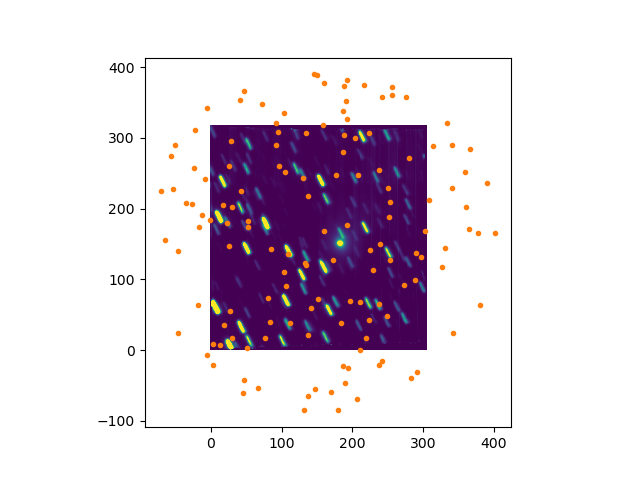

In [7]:
image = np.nanmean(data,axis=0)
image[np.isnan(image)] = 0
#image = gaussian_filter(image,3)
plt.figure()
plt.imshow(image,vmin=0,vmax=100,origin='lower')
plt.plot(x,y,'C1.')

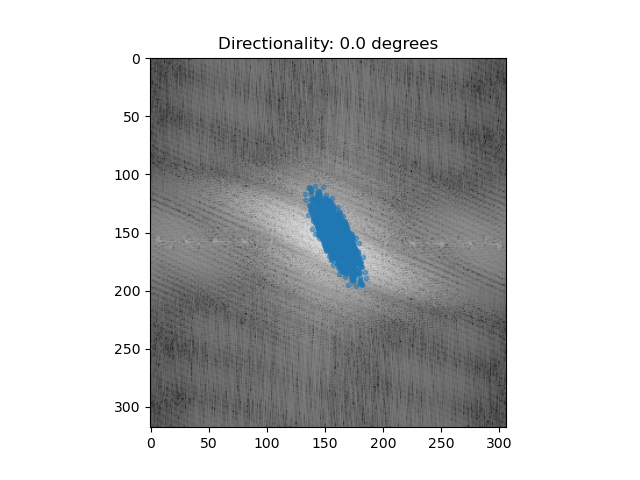

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Load the image
img = image

# Convert the image to grayscale
gray_img = img#np.mean(img, axis=2)

# Compute the 2D Fourier transform of the image
fft = np.fft.fft2(gray_img)

# Shift the zero-frequency component to the center of the spectrum
fft = np.fft.fftshift(fft)

# Compute the magnitude and power spectra
magnitude_spectrum = np.abs(fft)
power_spectrum = np.log10(np.square(magnitude_spectrum))

# Compute the orientation of each frequency component
orientation_spectrum = np.angle(fft)

# Create a meshgrid for the frequency domain axes
yfreq, xfreq = np.meshgrid(np.fft.fftfreq(gray_img.shape[0]), np.fft.fftfreq(gray_img.shape[1]))

# Plot the power spectrum as an image
plt.figure()
plt.imshow(power_spectrum, cmap='gray')

# Find the peak(s) in the power spectrum
peak_threshold = np.percentile(power_spectrum,99)#0.7 * np.max(power_spectrum)
peaks = np.where(power_spectrum >= peak_threshold)

# Compute the angle of the peak(s)
peak_angles = np.rad2deg(np.median(orientation_spectrum[peaks]))
plt.plot(peaks[0],peaks[1],'.',alpha=0.5)

# Draw a line indicating the direction of the peak(s)
#plt.plot([0, np.tan(np.deg2rad(peak_angles))], [-.5, .5], 'r-', linewidth=2)

# Show the image and the peak(s)
plt.title('Directionality: {} degrees'.format(peak_angles))
plt.show()


In [9]:
px = peaks[0] - np.mean(peaks[0])
py = -(peaks[1] - np.mean(peaks[1]))


In [10]:
m, c = np.polyfit(px, py, 1)
xx = np.arange(min(px),max(px)+1)

angle_radians = np.arctan2(m,1) # 1 is the length of the x-axis
# Convert the angle from radians to degrees
angle_degrees = -np.degrees(angle_radians)

In [11]:
angle_degrees

51.259739250705664

In [12]:
m

-1.2464081396865625

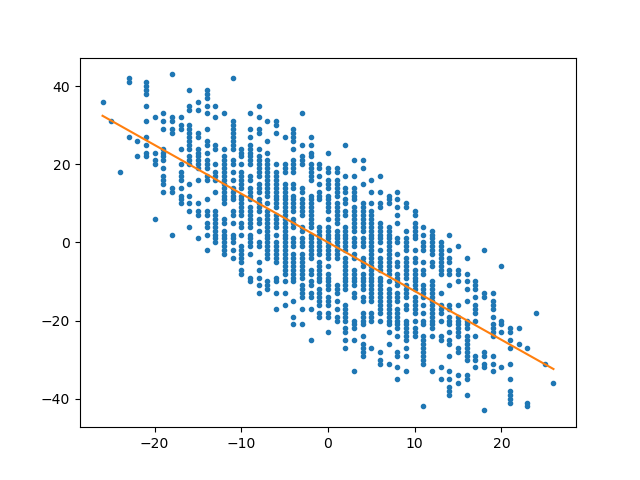

In [13]:
plt.figure()
plt.plot(px,py,'.')
plt.plot(xx,xx*m+c)

In [14]:
image = np.nanmean(data,axis=0)
image[np.isnan(image)] = 0
image = gaussian_filter(image,5)

In [15]:
mean, med, std = sigma_clipped_stats(image, sigma=3.0)

daofind = DAOStarFinder(fwhm=10,theta = angle_degrees,ratio=.5, threshold=3*std,exclude_border=True)
s = daofind(image - med)

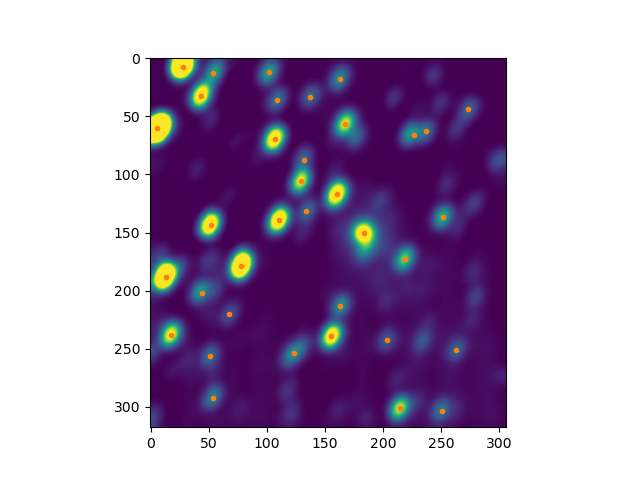

In [16]:
plt.figure()
plt.imshow(image,vmin=0,vmax=50)

plt.plot(s['xcentroid'],s['ycentroid'],'C1.')

In [17]:
def min_dist(x1,y1,x2,y2):
    dx = x1[:,np.newaxis] - x2[np.newaxis,:]
    dy = y1[:,np.newaxis] - y2[np.newaxis,:]
    d = np.sqrt(dx**2 + dy**2)
    md = np.nanmin(d,axis=1)
    return md

def minimize_dist(offset,x1,y1,x2,y2,image):
    cx = image.shape[1]/2; cy = image.shape[0]/2
    x = x1 + offset[0]
    y = y1 + offset[1]
    x = cx + ((x-cx)*np.cos(offset[2])-(y-cy)*np.sin(offset[2]))
    y = cy + ((x-cx)*np.sin(offset[2])+(y-cy)*np.cos(offset[2]))

    ind = (x > 0) & (x < image.shape[1]) & (y > 0) & (y < image.shape[0])
    x = x[ind]; y = y[ind]
    mdist = min_dist(x2,y2,x,y)
    return np.nanmean(mdist)

x0 = [0,0,0]

ind = cat['Gmag'].values < 20

x, y, lam = wcs.all_world2pix(cat.ra.values[ind],cat.dec.values[ind],0,0)

catx = x; caty = y
sourcex = s['xcentroid']; sourcey = s['ycentroid']

res = minimize(minimize_dist,x0,args=(catx,caty,sourcex,sourcey,image))

xx = x + res.x[0]
yy = y + res.x[1]
cx = image.shape[1]/2; cy = image.shape[0]/2
xx = cx + ((xx-cx)*np.cos(res.x[2])-(yy-cy)*np.sin(res.x[2]))
yy = cy + ((xx-cx)*np.sin(res.x[2])+(yy-cy)*np.cos(res.x[2]))

#ind = (xx > 0) & (xx < image.shape[1]) & (yy > 0) & (yy < image.shape[0])
#xx = xx[ind]; yy = yy[ind]

cut = min_dist(xx,yy,sourcex,sourcey) < 5
print('round 1: ',res.x)
res = minimize(minimize_dist,x0,args=(catx[cut],caty[cut],sourcex,sourcey,image))
print('round 2: ',res.x)


round 1:  [ 2.54794421e+01 -3.77603215e+00 -1.88835709e-03]
round 2:  [ 2.54957760e+01 -3.74466349e+00 -1.89042884e-03]


In [22]:
def transform_coords(x,y,param,image):
    xx = x + param[0]
    yy = y + param[1]
    cx = image.shape[1]/2; cy = image.shape[0]/2
    xx = cx + ((xx-cx)*np.cos(param[2])-(yy-cy)*np.sin(param[2]))
    yy = cy + ((xx-cx)*np.sin(param[2])+(yy-cy)*np.cos(param[2]))
    ind = (xx > 0) & (xx < image.shape[1]) & (yy > 0) & (yy < image.shape[0])
    #xx = xx[ind]; yy = yy[ind]
    return xx, yy

Querying regions with Vizier


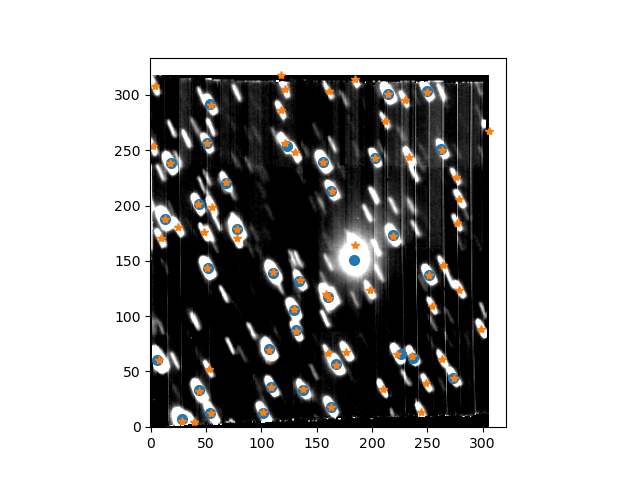

In [23]:
image = np.nanmean(data,axis=0)
image[np.isnan(image)] = 0
gaia = get_gaia_region([ra],[dec],size=50,magnitude_limit=25)
sm = get_skymapper_region([ra],[dec],size=50)

x, y, lam = wcs.all_world2pix(gaia.ra.values,gaia.dec.values,0,0)
smx, smy, lam = wcs.all_world2pix(sm.ra.values,sm.dec.values,0,0)

xx,yy = transform_coords(x,y,res.x,image)
smx,smy = transform_coords(smx,smy,res.x,image)

ind = (xx >= 0) & (xx < image.shape[1]) & (yy >= 0) & (yy < image.shape[0])

gaia['x'] = xx
gaia['y'] = yy
gaia = gaia.iloc[ind]

plt.figure()
plt.imshow(image,vmin=0,vmax=10,cmap='gray',origin='lower')
plt.plot(sourcex,sourcey,'o',ms=7)
plt.plot(gaia['x'],gaia['y'],'C1*')
#plt.plot(smx,smy,'C2*')


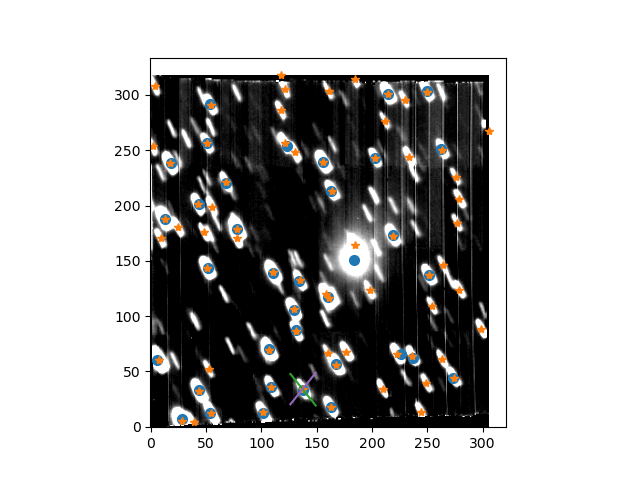

In [24]:
lx = np.arange(-11,12,0.1)
testx = lx + gaia['x'].iloc[10]
testy = lx*m+c + gaia['y'].iloc[10]
testyy = lx*-m+c + gaia['y'].iloc[10]
plt.figure()
plt.imshow(image,vmin=0,vmax=10,cmap='gray',origin='lower')
plt.plot(sourcex,sourcey,'o',ms=7)
plt.plot(gaia['x'],gaia['y'],'C1*')
plt.plot(testx,testy,'C2')
plt.plot(testx,testyy,'C4')

In [25]:
from scipy.interpolate import griddata

In [26]:
i = 25
lx = np.arange(-11,12,0.1)
testx = lx + gaia['x'].iloc[i]
testy = lx*m+c + gaia['y'].iloc[i]
testyy = lx*-m+c + gaia['y'].iloc[i]
dpix = np.sqrt((testx[0]-testx)**2+(testy[0]-testy)**2)

x = np.arange(0, image.shape[1])
y = np.arange(0, image.shape[0])
arr = np.ma.masked_invalid(image)
xx, yy = np.meshgrid(x, y)
#get only the valid values
x1 = xx[~arr.mask]
y1 = yy[~arr.mask]
newarr = arr[~arr.mask]
#print(x1,y1)

estimate = griddata((x1, y1), newarr.ravel(),
                          (testx,testy),method='linear')

ind = np.where(np.percentile(estimate[np.isfinite(estimate)],30) < estimate)[0]
trail_length = int(max(np.diff(ind))*1.2)

y_length = abs(int(trail_length/2 * np.sin(angle_radians)))
x_length = abs(int(trail_length/2 * np.cos(angle_radians)))

In [27]:
x = (gaia['x'].values + 0.5).astype(int); y = (gaia['y'].values + 0.5).astype(int)

In [400]:
def get_star_cuts(image,cat,norm=False):
    star_cuts = []
    x = (cat['x'].values + 0.5).astype(int); y = (cat['y'].values + 0.5).astype(int)
    good = []
    for i in range(len(cat)):
        if (x[i] +x_length+1 < image.shape[1]) & (x[i] - x_length >= 0) & (y[i] +y_length+1 < image.shape[1]) & (y[i] - y_length >= 0):
            dist = np.sqrt((x - x[i])**2 + (y - y[i])**2)
            dist[dist==0] = 100
            if np.min(dist) > 10:
                c = image[y[i]-y_length:y[i]+y_length+1,x[i]-x_length:x[i]+x_length+1]
                my,mx = np.where(np.max(c) == c)
                if (mx > 5) & (mx < c.shape[1]-5) & (my > 5) & (my < c.shape[0]-5):
                    star_cuts += [c]
                    good += [i]
    star_cuts = np.array(star_cuts)
    good = np.array(good)
    if norm:
        star_cuts = star_cuts / np.nansum(star_cuts,axis=(1,2))[:,np.newaxis,np.newaxis]
    return star_cuts, good

    
    
    
    

In [403]:
star_cuts, good = get_star_cuts(image,gaia)
psf = np.nansum(star_cuts,axis=0)
psf /= np.nansum(psf)
norm_star_cuts, good = get_star_cuts(image,gaia,True)
psf = np.nanmedian(norm_star_cuts,axis=0)

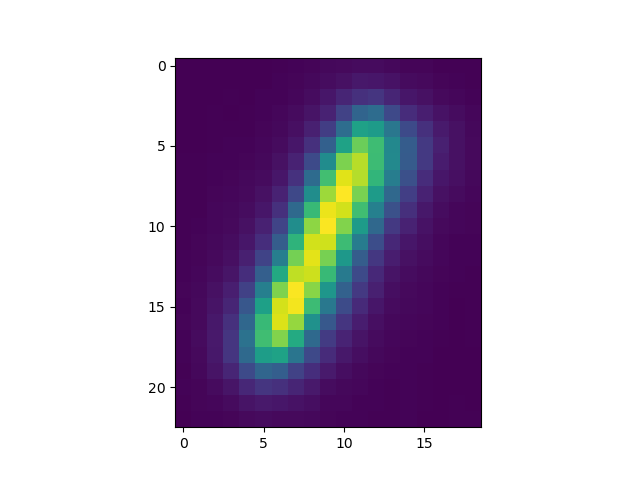

In [405]:
plt.figure()
plt.imshow(psf)

In [407]:
np.percentile(psf,70)

0.0017159868031740183

In [ ]:
'''flux, residual = psf_flux(cube_c[500],psfc)
plt.figure()
plt.subplot(121)
plt.imshow(cube_c[500])
plt.subplot(122)
plt.imshow(residual)'''

In [531]:
def minimize_psf_scene(flux,image,psf):
    res = np.nansum(abs(image - psf*flux))
    return res

def psf_flux(image,psf):
    mask = np.zeros_like(psf)
    mask[psf > np.percentile(psf,70)] = 1
    f0 = np.nansum(image*mask)
    res = minimize(minimize_psf_scene,f0,args=(image,psf),method='Nelder-Mead')
    flux = res.x
    residual = abs(image - psf*flux)
    return flux, residual


def get_spec(cube,psf):
    flux = np.zeros(len(cube))
    for i in range(len(flux)):
        f,_ = psf_flux(cube[i],psf)
        flux[i] = f
    return flux

In [592]:
x = (gaia['x'].values + 0.5).astype(int); y = (gaia['y'].values + 0.5).astype(int)
ind = 30#62
cube_c = cube[:,y[ind]-y_length:y[ind]+y_length+1,x[ind]-x_length:x[ind]+x_length+1]

In [593]:
func = np.zeros_like(cube[0])
func[y[ind],x[ind]] = 1
func = signal.fftconvolve(func, psf, mode='same')
psfc = func[y[ind]-y_length:y[ind]+y_length+1,x[ind]-x_length:x[ind]+x_length+1]
mask = np.zeros_like(psfc)
mask[psfc > np.percentile(psfc,70)] = 1

In [594]:
flux = get_spec(cube_c,psfc)

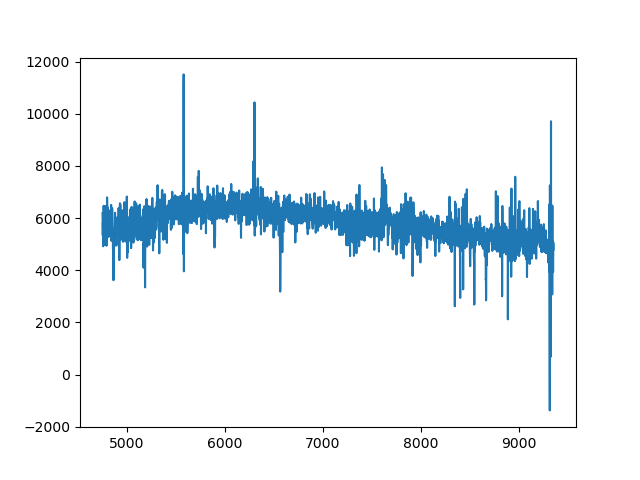

In [595]:
plt.figure()
plt.plot(lam,flux)

In [596]:
mags = gaia.iloc[good].Gmag.values
bleh = np.argsort(mags)

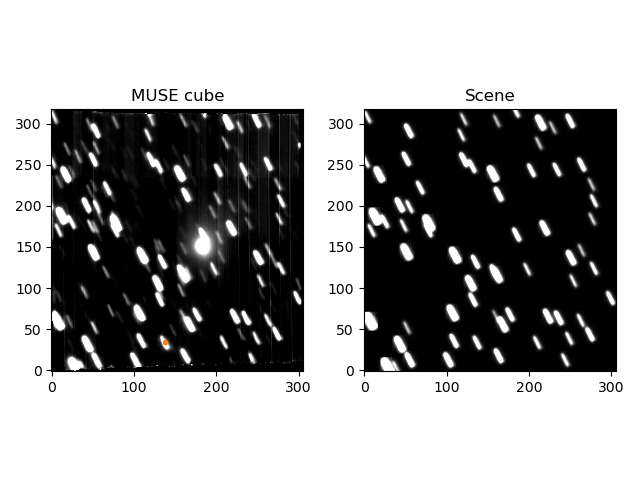

In [33]:
ind = 10
plt.figure()
plt.subplot(121)
plt.title('MUSE cube')
ni = image/image[y[ind],x[ind]]
plt.imshow(ni,vmin=0,vmax=np.percentile(ni,95),cmap='gray',origin='lower')
plt.plot(x[ind],y[ind],'C1.')

plt.subplot(122)
plt.title('Scene')
nt = test/test[y[ind],x[ind]]
plt.imshow(nt,vmin=0,vmax=np.percentile(nt,95),cmap='gray',origin='lower')
plt.tight_layout()
#plt.savefig('first_scene.png',bbox_inches='tight')

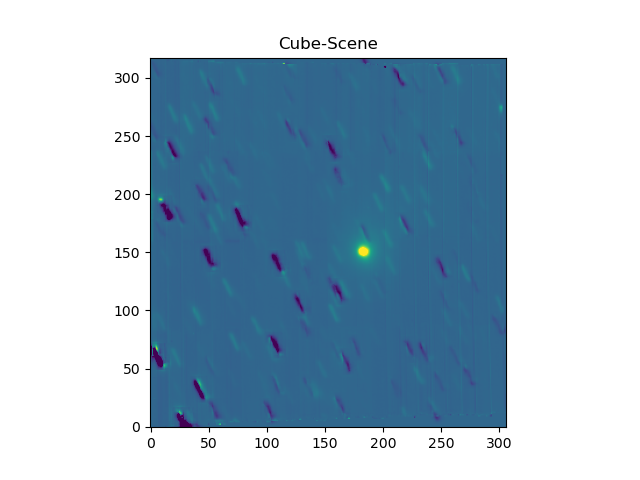

In [34]:
plt.figure()
plt.title('Cube-Scene')
plt.imshow((ni-nt),origin='lower',vmin=-1,vmax=2)



## spectra time

In [494]:
from scipy.signal import savgol_filter
from scipy.stats import pearsonr
from scipy.interpolate import interp1d
#_,_,lam = wcs.all_pix2world(0,0,np.arange(0,len(cube)),0)
#lam = lam * 1e10

#ind = #np.argmin(gaia.Gmag.values)

In [597]:

spec = S.ArraySpectrum(wave=lam,flux=flux*1e-20,fluxunits='flam')
spec_s = savgol_filter(spec.flux,501,1)

Warning, 1 of 3681 bins contained negative fluxes; they have been set to zero.


In [598]:
def match_spec_to_model(spec,model='eso'):
    lam = spec.wave
    flux = spec.flux
    if model.lower() == 'ck':
        cks = glob('../core/data/ck_spec/*')
        cks.sort()
        cors = []
        for i in range(len(cks)):
            ck = at.Table.read(cks[i], format='ascii')
            func = interp1d(ck['wave'].value,ck['flux'].value,bounds_error=False,fill_value='extrapolate',kind='linear')
            interp = func(lam)
            corr = pearsonr(flux,interp)[0]
            cors += [corr]
        cors = np.array(cors)
        ind = np.argmax(cors)
        name = cks[ind].split('/')[-1].split('.dat')[0]
        ck = at.Table.read(cks[ind], format='ascii')
        model = S.ArraySpectrum(wave=ck['wave'].value,
                                    flux=ck['flux'].value,fluxunits='flam',name=name)
    
    elif model.lower() == 'eso':
        esos = glob('../core/data/eso_spec/*')
        esos.sort()
        cors = []
        for i in range(len(esos)):
            eso = at.Table.read(esos[i], format='ascii')
            func = interp1d(eso['col1'].value,eso['col2'].value,bounds_error=False,fill_value='extrapolate',kind='linear')
            interp = func(lam)
            corr = pearsonr(flux,interp)[0]
            cors += [abs(corr)]
        cors = np.array(cors)
        ind = np.argmax(cors)
        name = esos[ind].split('/')[-1].split('.dat')[0]
        eso = at.Table.read(esos[ind], format='ascii')
        model = S.ArraySpectrum(wave=eso['col1'].value,
                                    flux=eso['col2'].value,fluxunits='flam',name=name)
    cor = cors[ind]
    return model, cor

from extinction import fitzpatrick99, apply

def ebv_minimiser(ebv,model,spec,Rv=3.1):
    ext = S.ArraySpectrum(model.wave, 
                    apply(fitzpatrick99(model.wave.astype('double'),ebv*Rv,Rv),model.flux))
    interp = ext.sample(spec.wave)
    corr = pearsonr(spec.flux,interp)[0]
    res = 1 - 1/corr
    return res

def fit_extinction(model,spec,Rv = 3.1):
    lam = spec.wave
    ebv0 = 0
    bounds = [[0,10]]
    res = minimize(ebv_minimiser, ebv0,args=(model,spec,Rv),method='Nelder-Mead',bounds=bounds)
    ebv = res.x
    ext = S.ArraySpectrum(model.wave, 
                    apply(fitzpatrick99(model.wave.astype('double'),ebv*Rv,Rv),model.flux),name=model.name + ' ebv=' + str(np.round(ebv[0],2)))
    return ext 

    
    


In [599]:
model,cor = match_spec_to_model(spec,'eso')
#model = fit_extinction(model,spec)

In [600]:
model.name

'ukrk1iii'

In [601]:
cor

0.6869780763684245

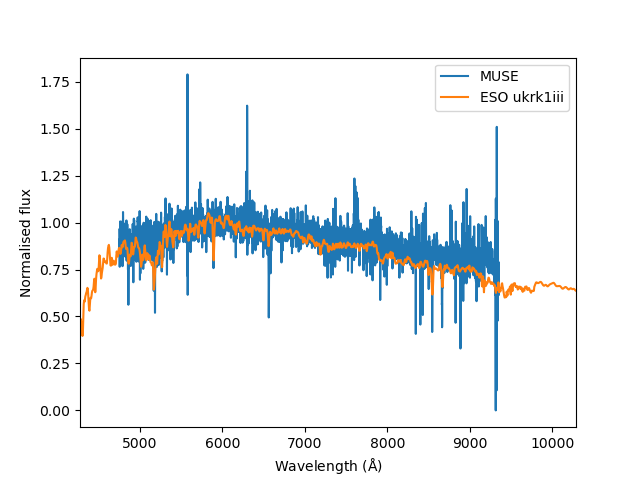

In [602]:
plt.figure()
plt.plot(spec.wave,spec.flux/np.nanmax(spec_s),label='MUSE')
#plt.plot(ck['wave'],ck['flux']/np.nanmax(ck['flux']))
plt.plot(model.wave,model.flux/np.nanmax(model.flux)+0.05,'-',label='ESO ' + model.name)
plt.xlim(min(lam)*0.9,max(lam)*1.1)
plt.ylabel('Normalised flux')
plt.xlabel(r'Wavelength ($\rm \AA$)')
plt.legend()
#plt.savefig('Spec_match_example.png')


In [609]:
def Syn_mag(pbs,spec):
    mag = {}
    for pb in pbs:
        if spec is not None:
            syn_mag = synphot(spec,pbs[pb][0],zp=pbs[pb][1])
        else:
            syn_mag = np.nan
        mag[pb] = syn_mag
        
    return mag

def my_norm(Spec,pbs,mag):
    spec = deepcopy(Spec)
    m = Syn_mag(pbs,spec)
    print(m)
    m=m[list(pbs.keys())[0]]
    factor = 10**(-2/5*(mag-m))
    print(factor)
    spec = S.ArraySpectrum(wave=spec.wave,waveunits=spec.waveunits,
                                   flux=spec.flux*factor,fluxunits=spec.fluxunits)
    return spec


svo_bp=['GAIA/GAIA3.G']

pbs = load_pbs(svo_bp,0,'AB',SVO=True)


model2 = my_norm(model,pbs,np.array([gaia.Gmag.values[ind]-0.5]))
gaia.Gmag.values[ind]

SVO
{'GAIA/GAIA3.G': -21.236591343610396}
[7.58407576e-17]


19.563652

Text(0.5, 0, 'Wavelength [$\\rm \\AA$]')

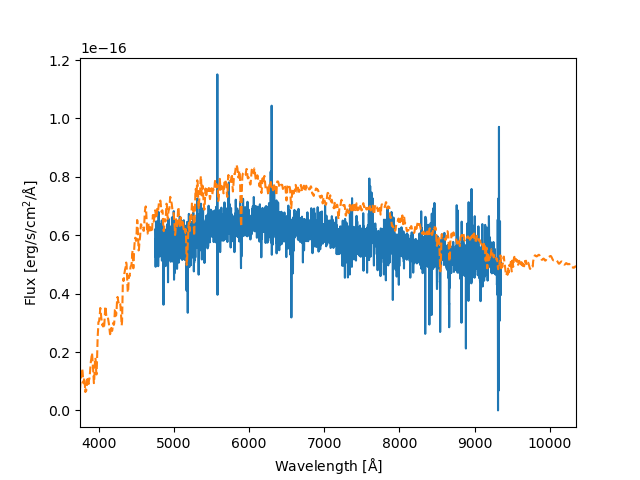

In [610]:
plt.figure()
plt.plot(spec.wave,spec.flux)
plt.plot(model2.wave,model2.flux,'--')
plt.xlim(min(lam)-1000,max(lam)+1000)
plt.ylabel(r'Flux [$\rm erg/s/cm^2/\AA$]')
plt.xlabel(r'Wavelength [$\rm \AA$]')
#plt.savefig('scaled_spec.png')

In [ ]:
x = (gaia['x'].values + 0.5).astype(int); y = (gaia['y'].values + 0.5).astype(int)
diffs = []
for i in range(len(x)):
    try:
        spec = get_spec(cube,x[i],y[i],psf)
        s = S.ArraySpectrum(wave=lam,flux=spec*1e-20,fluxunits='flam')
        obs = Syn_mag(pbs,s)
        diff = obs['GAIA/GAIA3.G'] - gaia.Gmag.values[i]
        diffs += [diff]
    except:
        print('bleh')
diffs = np.array(diffs)

In [128]:
hdul[0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                    8 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
DATE    = '2020-04-14T12:21:53' / file creation date (YYYY-MM-DDThh:mm:ss UT)   
ORIGIN  = 'ESO-PARANAL'        / European Southern Observatory                  
TELESCOP= 'ESO-VLT-U4'         / ESO <TEL>                                      
INSTRUME= 'MUSE    '           / Instrument used.                               
RA      =           192.866371 / [deg] 12:51:27.9 RA (J2000) pointing           
DEC     =            -69.13484 / [deg] -69:08:05.4 DEC (J2000) pointing         
EQUINOX =                200

In [62]:
list(pbs.keys())

['GAIA/GAIA3.G']

In [53]:
G = gaia['Gmag'].values
B = gaia['BPmag'].values
R = gaia['RPmag'].values
mags = np.array([B,G,R]).T

cube_mangle([model],[mags[5]])

SVO
SVO
SVO
4771
(array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        6.12817104e-18, 6.11516393e-18, 0.00000000e+00]]), {'allbands': None, 'ave_waves': None, 'bands': ['GAIA/GAIA3.Gbp', 'GAIA/GAIA3.G', 'GAIA/GAIA3.Grp'], 'resp_rats': None, 'mfactors': None}, array([ 0.66763927, -0.353586  ,  1.09935671]))


ValueError: wave and flux arrays must be of equal length

In [486]:
G = gaia['Gmag'].values
B = gaia['BPmag'].values
R = gaia['RPmag'].values

gbp = G - B
grp = G - R
bprp = B - R

In [484]:
syn = pd.read_csv('../core/data/ckmodel_Gaia_colors.csv')

In [487]:
diff = np.sqrt((gbp[:,np.newaxis] - syn['G-Bp'].values[np.newaxis,:])**2 + (grp[:,np.newaxis] - syn['G-Rp'].values[np.newaxis,:])**2 + (bprp[:,np.newaxis] - syn['Bp-Rp'].values[np.newaxis,:])**2)

In [488]:
inds = np.argmin(diff,axis=1)

In [489]:
matched = syn.iloc[inds]

In [490]:
matched

model      G-Bp      G-Rp     Bp-Rp
0   ckmod11900_0.0_4.00.dat  0.147144 -0.334759 -0.481903
19   ckmod3850_0.0_4.50.dat -0.769747  0.682193  1.451940
22   ckmod4060_0.0_4.50.dat -0.658513  0.609473  1.267986
22   ckmod4060_0.0_4.50.dat -0.658513  0.609473  1.267986
19   ckmod3850_0.0_4.50.dat -0.769747  0.682193  1.451940
..                      ...       ...       ...       ...
21   ckmod3950_0.0_1.50.dat -0.691966  0.624646  1.316612
22   ckmod4060_0.0_4.50.dat -0.658513  0.609473  1.267986
13   ckmod3500_0.0_5.00.dat -1.003906  0.804899  1.808806
14   ckmod3580_0.0_4.50.dat -0.954538  0.783893  1.738431
23   ckmod4350_0.0_4.50.dat -0.534785  0.519873  1.054658

[70 rows x 4 columns]

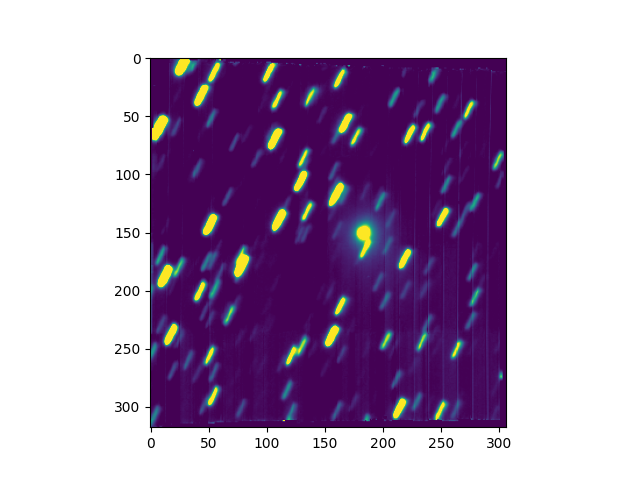

In [32]:
plt.figure()
plt.imshow(np.nanmean(data,axis=0),vmin=0,vmax=50)


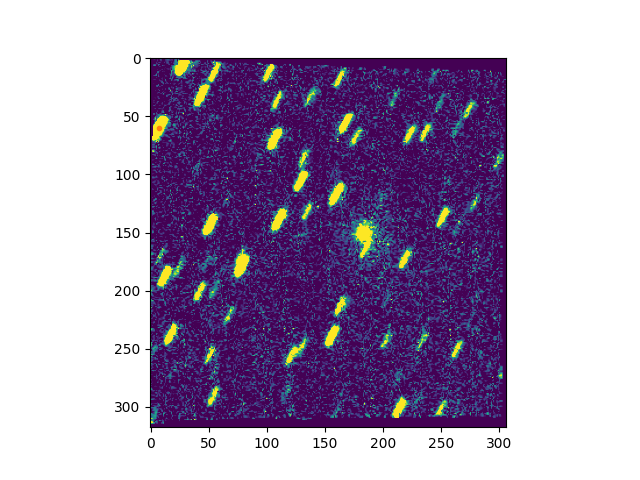

In [22]:
ind = np.argmin(gaia['Gmag'].values)
plt.figure()
plt.imshow(data[500],vmin=0,vmax=50)
plt.plot(int(gaia['x'].values[ind]),int(gaia['y'].values[ind]),'C1.')

In [23]:
ck = at.Table.read('/home/phys/astronomy/rri38/cube_scene/core/data/ck_spec/'+matched.iloc[ind]['model'], format='ascii')

In [24]:
x,y,lam = wcs.all_pix2world(0,0,np.arange(0,len(data)),0)

(3750.21533203125, 10350.21533203125)

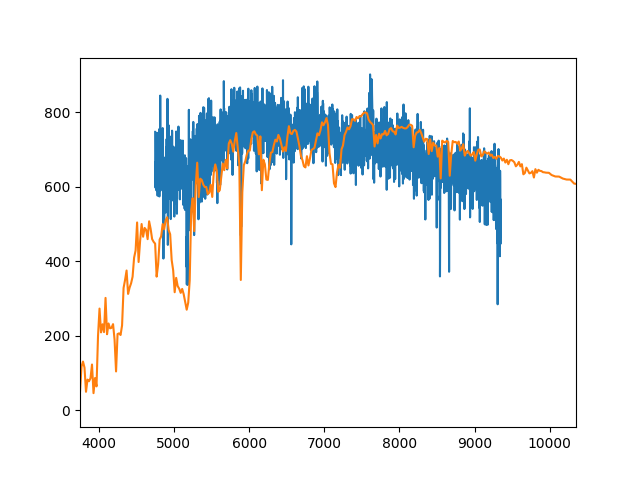

In [25]:
plt.figure()
plt.plot(lam*1e10,data[:,int(gaia['y'].values[58]),int(gaia['x'].values[58])])
plt.plot(ck['wave'],ck['flux']/np.nanmax(ck['flux'])*800)
plt.xlim(min(lam*1e10)-1000,max(lam*1e10)+1000)

In [26]:
mags = np.array([B,G,R]).T

In [27]:
cube_mangle(matched['model'].values,mags)

SVO
SVO
SVO
OrderedDict([('GAIA/GAIA3.Gbp', (<pysynphot.spectrum.ArraySpectralElement object at 0x7f86701e0460>, -2.094986479118612e+01)), ('GAIA/GAIA3.G', (<pysynphot.spectrum.ArraySpectralElement object at 0x7f86702590d0>, -21.375993149393477)), ('GAIA/GAIA3.Grp', (<pysynphot.spectrum.ArraySpectralElement object at 0x7f86701ee100>, -21.859714513454705))])
[      nan 20.702034       nan]
1221
[nan nan nan ... nan nan nan]
OrderedDict([('GAIA/GAIA3.Gbp', (<pysynphot.spectrum.ArraySpectralElement object at 0x7f86701e0460>, -20.94986479118612)), ('GAIA/GAIA3.G', (<pysynphot.spectrum.ArraySpectralElement object at 0x7f86702590d0>, -21.375993149393477)), ('GAIA/GAIA3.Grp', (<pysynphot.spectrum.ArraySpectralElement object at 0x7f86701ee100>, -21.859714513454705))])
[17.580181 16.921877 16.138477]
1221
(array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        6.53583573e-23, 3.52062488e-23, 2.05931175e-23]]), {'allbands': None, 'ave_waves': None, 'bands': ['GAIA/GAIA3.Gbp', 'GAIA

ValueError: wave and flux arrays must be of equal length

In [ ]:
mags[i,1]

16.921877

In [ ]:
def Syn_mag(pbs,spec):
    mag = {}
    for pb in pbs:
        if spec is not None:
            syn_mag = synphot(spec,pbs[pb][0],zp=pbs[pb][1])
        else:
            syn_mag = np.nan
        mag[pb] = syn_mag
        
    return mag

def my_norm(Spec,pbs,mag):
    spec = deepcopy(Spec)
    m = Syn_mag(pbs,spec)
    m=m['GAIA/GAIA3.G']
    factor = 10**(-2/5*(mag-m))
    spec = S.ArraySpectrum(wave=spec.wave,waveunits=spec.waveunits,
                                   flux=spec.flux*factor,fluxunits=spec.fluxunits)
    return spec

spec_files = matched['model'].values


svo_bp=['GAIA/GAIA3.G']

pbs = load_pbs(svo_bp,0,'AB',SVO=True)
mangled = []
for i in range(2):
    spec = at.Table.read(package_dir + spec_files[i], format='ascii')
    spec = S.ArraySpectrum(wave=spec['wave'].value,
                                    flux=spec['flux'].value,fluxunits='flam')
    print(pbs)
    print(mags[i])
    if np.isfinite(mags[i]).all():
        #flux = mangle_spectrum2(spec.wave,spec.flux,pbs,np.array([mags[i,1]]))
        spec2 = my_norm(spec,pbs,np.array([mags[i,1]]))
    else:
        flux = spec.flux * np.nan
    print(len(spec.wave))
    print(flux)

    #spec2 = S.ArraySpectrum(wave=spec.wave,
     #                               flux=flux,fluxunits='flam')
    mangled += [spec2]

SVO
OrderedDict([('GAIA/GAIA3.G', (<pysynphot.spectrum.ArraySpectralElement object at 0x7fc61af039d0>, -21.375993149393477))])
[      nan 20.702034       nan]
1221
[nan nan nan ... nan nan nan]
OrderedDict([('GAIA/GAIA3.G', (<pysynphot.spectrum.ArraySpectralElement object at 0x7fc61af039d0>, -21.375993149393477))])
[17.580181 16.921877 16.138477]
1221
[nan nan nan ... nan nan nan]


In [ ]:
spec2.flux

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       2.28026005e-23, 1.22829591e-23, 7.18464555e-24])

In [ ]:
spec.flux

array([0.      , 0.      , 0.      , ..., 0.037838, 0.020382, 0.011922])

In [ ]:
pbs

OrderedDict([('GAIA/GAIA3.Gbp',
              (<pysynphot.spectrum.ArraySpectralElement at 0x7fc6e90de790>,
               -20.94986479118612)),
             ('GAIA/GAIA3.G',
              (<pysynphot.spectrum.ArraySpectralElement at 0x7fc61bea6df0>,
               -21.375993149393477)),
             ('GAIA/GAIA3.Grp',
              (<pysynphot.spectrum.ArraySpectralElement at 0x7fc61be8c700>,
               -21.859714513454705))])

In [37]:
mags[i]

array([17.580181, 16.921877, 16.138477])

In [38]:
flux

(array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         6.53583573e-23, 3.52062488e-23, 2.05931175e-23]]),
 {'allbands': None,
  'ave_waves': None,
  'bands': ['GAIA/GAIA3.Gbp', 'GAIA/GAIA3.G', 'GAIA/GAIA3.Grp'],
  'resp_rats': None,
  'mfactors': None},
 array([ 1.43240369, -1.0271856 ,  1.37540149]))

In [65]:
spec2.fluxunits

(3750.21533203125, 10350.21533203125)

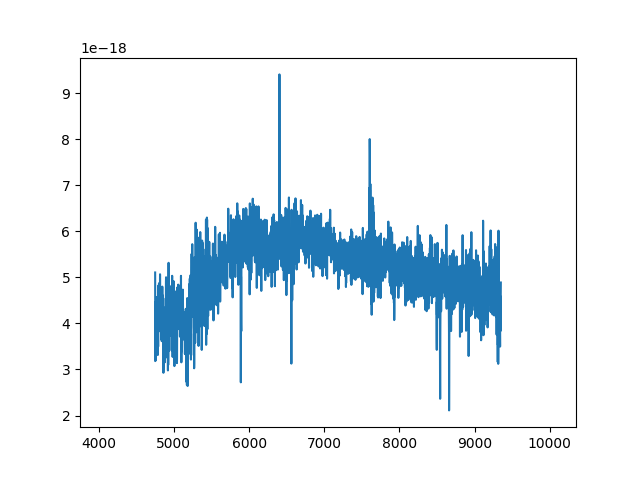

In [74]:
plt.figure()
plt.plot(lam*1e10,data[:,int(gaia['y'].values[1]),int(gaia['x'].values[1])]*10**-20)
plt.plot(spec2.wave,spec2.flux)
#plt.plot(spec.wave,spec.flux)

#plt.plot(ck['wave'],ck['flux']/np.nanmax(ck['flux'])*800)
plt.xlim(min(lam*1e10)-1000,max(lam*1e10)+1000)

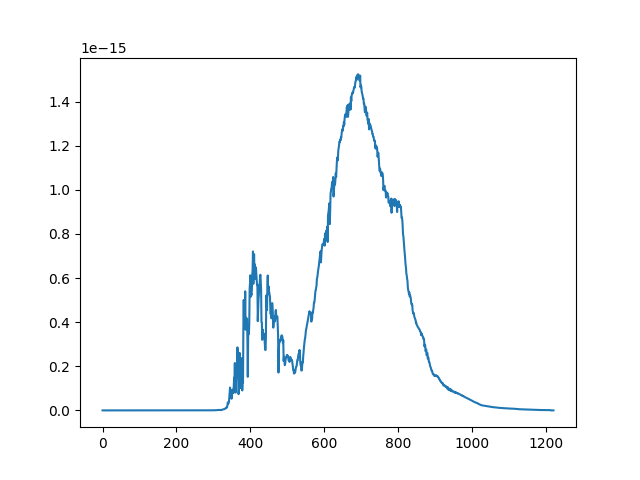

In [32]:
plt.figure()
plt.plot(flux[0][0])

In [266]:
G = cat['Gmag'].values
B = cat['BPmag'].values
R = cat['RPmag'].values

In [1]:
wcs

NameError: name 'wcs' is not defined

In [26]:
ck['wave'].value

array([9.09000015e+01, 9.35000000e+01, 9.60999985e+01, ...,
       1.20000000e+06, 1.40000000e+06, 1.60000000e+06])

In [69]:
hdul[0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                    8 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
DATE    = '2020-04-14T12:21:53' / file creation date (YYYY-MM-DDThh:mm:ss UT)   
ORIGIN  = 'ESO-PARANAL'        / European Southern Observatory                  
TELESCOP= 'ESO-VLT-U4'         / ESO <TEL>                                      
INSTRUME= 'MUSE    '           / Instrument used.                               
RA      =           192.866371 / [deg] 12:51:27.9 RA (J2000) pointing           
DEC     =            -69.13484 / [deg] -69:08:05.4 DEC (J2000) pointing         
EQUINOX =                200